### Libraries Import

In [1]:
# Importa todas as bibliotecas
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import os
import tensorflow as tf
from keras import layers
from keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

### Aux. Functions

In [2]:
def load_data(image_dir, mask_dir):
    """
    Encontra e pareia os caminhos das imagens com suas 
    respectivas máscaras de segmentação.
    """
    file_list = []

    # Garante que os arquivos estão ordenados para o pareamento correto
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for image_file, mask_file in zip(image_files, mask_files):
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)
        
        if os.path.exists(mask_path):
            # Ler a máscara para determinar o rótulo
            mask_itk = sitk.ReadImage(mask_path)
            mask_np = sitk.GetArrayFromImage(mask_itk)
            
            # O rótulo é 1 se houver qualquer pixel não-zero na máscara, senão 0
            label = 1 if np.sum(mask_np) > 0 else 0
            
            file_list.append({
                "image": image_path,
                "mask": mask_path,
                "label": label
            })
        else:
            print(f"Aviso: Máscara não encontrada para {image_path}")
            
    return file_list

def load_data_OpenNeuro(image_dir, file_list, label):
    """
    Encontra e pareia os caminhos das imagens com suas 
    respectivas máscaras de segmentação.
    """

    # Garante que os arquivos estão ordenados para o pareamento correto
    image_files = sorted(os.listdir(image_dir))

    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
            
        file_list.append({
            "image": image_path,
            "mask": None,
            "label": label
        })
            
    return file_list

In [3]:
# --- Hiperparâmetros ---
INPUT_SHAPE = (150, 150, 150, 2)
TARGET_SHAPE_3D = (150, 150, 150)
NUM_PATCHES = INPUT_SHAPE[2]

POOL_SIZE = 3
PATCH_H_REDIM = INPUT_SHAPE[0] // POOL_SIZE
PATCH_W_REDIM = INPUT_SHAPE[1] // POOL_SIZE
PATCH_CHANNELS = INPUT_SHAPE[3]
PATCH_DIM = PATCH_H_REDIM * PATCH_W_REDIM * PATCH_CHANNELS

PROJECTION_DIM = 768
NUM_HEADS = 12
TRANSFORMER_LAYERS = 8
MLP_DIM = 3072


# --- Bloco Transformer ---
def build_transformer_block(x, num_heads, projection_dim, mlp_dim, dropout=0.3):
    residual_1 = x
    x_norm1 = layers.LayerNormalization(epsilon=1e-6)(x)
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, 
        key_dim=projection_dim // num_heads, 
        dropout=dropout
    )(x_norm1, x_norm1)
    x = layers.Add()([attention_output, residual_1])
    
    residual_2 = x
    x_norm2 = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dense(mlp_dim, activation="gelu")(x_norm2)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(projection_dim)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Add()([x, residual_2])
    return x

# --- ViT "Clássico" com Redimensionamento de Patch ---
def build_vit_3d_classic(input_shape, patch_dim=PATCH_DIM, num_patches=NUM_PATCHES, 
                                 projection_dim=PROJECTION_DIM, transformer_layers=TRANSFORMER_LAYERS):
    
    inputs = layers.Input(shape=input_shape)
    
    # 1. Permutar os eixos para (Batch, D, H, W, C)
    x = layers.Permute((3, 1, 2, 4))(inputs)

    # 2. Reduzir a resolução de cada fatia (patch)
    slice_resizer = Sequential([
        layers.Input(shape=(input_shape[0], input_shape[1], input_shape[3])), # (150, 150, 2)
        layers.AveragePooling2D(pool_size=POOL_SIZE) # (30, 30, 2)
    ], name="slice_resizer")
    x = layers.TimeDistributed(slice_resizer)(x)

    # 3. Achatar cada fatia redimensionada
    patches = layers.Reshape((num_patches, patch_dim))(x)
    
    # 4. Projeção Linear (Patch Embedding)
    patch_embeddings = layers.Dense(units=projection_dim)(patches)
    
    # 5. Adicionar Positional Embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )(positions)
    
    encoded_patches = patch_embeddings + position_embedding
    
    # 6. Pilha de Encoders Transformer
    x = encoded_patches
    for _ in range(transformer_layers):
        x = build_transformer_block(x, NUM_HEADS, PROJECTION_DIM, MLP_DIM)
        
    # 7. Cabeça de Classificação
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x) 
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [4]:
# Função de plot do treinamento do modelo
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Função de plot da matriz de confusão
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


### Carregamento das imagens

In [5]:
# Carregar os pares de caminhos
IMAGE_DIR = "Patients_Displasya/T1"
IMAGE_DIR_CONTROL_OPENNEURO = "Patients_Control_OpenNeuro/T1"
IMAGE_DIR_DISPLASYA_OPENNEURO = "Patients_Displasya_OpenNeuro/T1"

MASK_DIR = "Mascaras"
file_list_original = load_data(IMAGE_DIR, MASK_DIR)
file_list = load_data_OpenNeuro(IMAGE_DIR_CONTROL_OPENNEURO, [], 0)
file_list = load_data_OpenNeuro(IMAGE_DIR_DISPLASYA_OPENNEURO, file_list, 1)

### Divisão das classes

In [6]:
# Verificar o balanceamento das classes
labels = [item['label'] for item in file_list]
print(f"Total de amostras encontradas: {len(file_list)}")
print(f"Amostras com lesão (label 1): {np.sum(labels)}")
print(f"Amostras saudáveis (label 0): {len(labels) - np.sum(labels)}")

train_files, val_files = train_test_split(file_list, test_size=0.25, random_state=42, stratify=labels)

print(f"Amostras de treino: {len(train_files)}")
print(f"Amostras de validação: {len(val_files)}")
print(f"Amostras de teste: {len(file_list_original)}")

Total de amostras encontradas: 170
Amostras com lesão (label 1): 85
Amostras saudáveis (label 0): 85
Amostras de treino: 127
Amostras de validação: 43
Amostras de teste: 41


### Preparação do modelo + Treinamento

In [7]:
# Construir o modelo ViT clássico
model = build_vit_3d_classic(
    INPUT_SHAPE
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 15 0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 150, 150, 150 0           input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 150, 50, 50,  0           permute[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 150, 5000)    0           time_distributed[0][0]           
______________________________________________________________________________________________

In [8]:
def load_and_preprocess_image(image_path, label):
    def _read_and_resize_nifti(path):
        # Decodificar o tensor de bytes para uma string Python
        path = path.numpy().decode('utf-8')
        
        nifti_image = nib.load(path).get_fdata().astype(np.float32)
        
        # Obter a forma original e calcular o fator de zoom para cada eixo
        original_shape = nifti_image.shape
        zoom_factors = [
            TARGET_SHAPE_3D[0] / original_shape[0],
            TARGET_SHAPE_3D[1] / original_shape[1],
            TARGET_SHAPE_3D[2] / original_shape[2]
        ]
        
        resized_image = zoom(nifti_image, zoom_factors, order=1)
        
        return resized_image

    image = tf.py_function(
        func=_read_and_resize_nifti, 
        inp=[image_path], 
        Tout=tf.float32
    )
    
    image.set_shape(TARGET_SHAPE_3D)
    
    # O resto do pré-processamento continua igual
    image = tf.expand_dims(image, axis=-1)
    image = tf.repeat(image, repeats=INPUT_SHAPE[3], axis=-1)
    image = image / (tf.reduce_max(image) + 1e-6) 
    image.set_shape(INPUT_SHAPE)
    
    return image, label

# Extrair os caminhos e rótulos das nossas listas
train_paths = [item['image'] for item in train_files]
train_labels = [item['label'] for item in train_files]
val_paths = [item['image'] for item in val_files]
val_labels = [item['label'] for item in val_files]
test_paths = [item['image'] for item in file_list_original]
test_labels = [item['label'] for item in file_list_original]

# Definir o batch_size
batch_size = 4

# Criar o dataset de treino com .batch()
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Criar o dataset de validação com .batch()
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Criar o dataset de validação com .batch()
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
# Compilando o modelo híbrido
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
)

# Histórico do treinamento
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50)

print("Treinamento concluído.")

Epoch 1/50
32/32 [==============================] - 28s 626ms/step - loss: 1.0249 - accuracy: 0.5039 - precision: 0.5077 - recall: 0.5156 - val_loss: 0.7080 - val_accuracy: 0.4884 - val_precision: 0.4884 - val_recall: 1.0000
Epoch 2/50
32/32 [==============================] - 14s 409ms/step - loss: 0.7329 - accuracy: 0.4803 - precision: 0.4800 - recall: 0.3750 - val_loss: 0.8297 - val_accuracy: 0.4884 - val_precision: 0.4884 - val_recall: 1.0000
Epoch 3/50
32/32 [==============================] - 14s 414ms/step - loss: 0.8351 - accuracy: 0.5512 - precision: 0.5467 - recall: 0.6406 - val_loss: 0.8154 - val_accuracy: 0.4884 - val_precision: 0.4884 - val_recall: 1.0000
Epoch 4/50
32/32 [==============================] - 14s 412ms/step - loss: 0.7639 - accuracy: 0.4882 - precision: 0.4938 - recall: 0.6250 - val_loss: 0.7557 - val_accuracy: 0.5116 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
32/32 [==============================] - 14s 418ms/step - loss: 0.7338 - accuracy

### Avaliação do treinamento do modelo

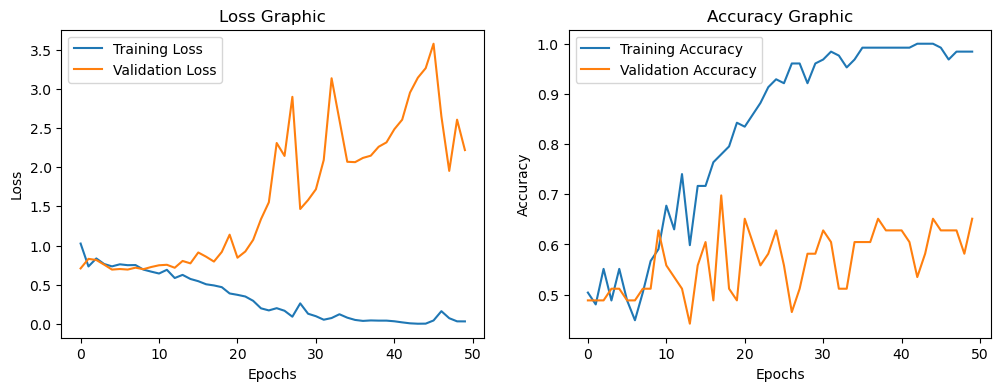

In [10]:
plot_training_history(history)

Validação:
              precision    recall  f1-score   support

           0       0.65      0.68      0.67        22
           1       0.65      0.62      0.63        21

    accuracy                           0.65        43
   macro avg       0.65      0.65      0.65        43
weighted avg       0.65      0.65      0.65        43


#########################################################

Teste:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.29      0.45        41

    accuracy                           0.29        41
   macro avg       0.50      0.15      0.23        41
weighted avg       1.00      0.29      0.45        41

Validação:


c:\Users\gabri\miniconda3\envs\displasia\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gabri\miniconda3\envs\displasia\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gabri\miniconda3\envs\displasia\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


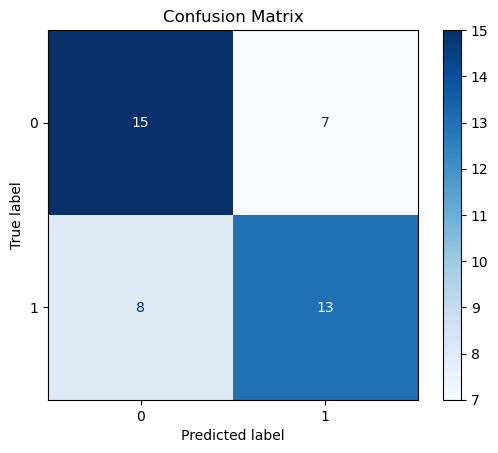

Teste:


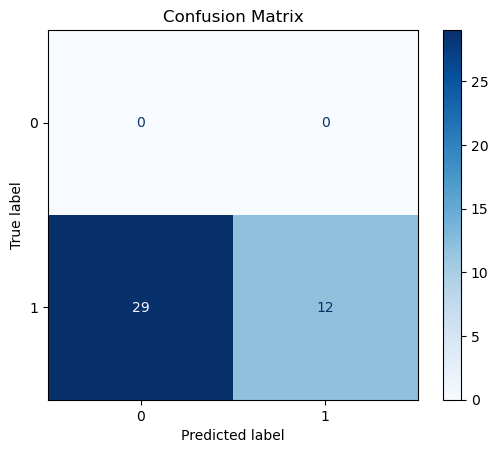

In [11]:
# Avaliar o modelo na validação e teste
y_pred_valid = (model.predict(val_dataset) > 0.5).astype(int)
y_pred_test = (model.predict(test_dataset) > 0.5).astype(int)

# Gerar o relatório de classificação
print("Validação:")
print(classification_report(val_labels, y_pred_valid))
print("\n#########################################################\n")

print("Teste:")
print(classification_report(test_labels, y_pred_test)) 

# Gerar a matriz de confusão
print("Validação:")
plot_confusion_matrix(val_labels, y_pred_valid)
print("Teste:")
plot_confusion_matrix(test_labels, y_pred_test)

### Plot em PDF das Predições

In [12]:
# Para garantir que os plots apareçam no notebook
%matplotlib inline 

def view_interactive_slices(dataset, y_true, y_pred, patient_index):
    """
    Cria um visualizador interativo com slider para um paciente específico.
    
    Args:
        dataset (tf.data.Dataset): Dataset de onde extrair as imagens.
        y_true (list or np.array): Lista de rótulos verdadeiros.
        y_pred (np.array): Array de rótulos preditos.
        patient_index (int): O índice do paciente/volume que você quer visualizar.
    """
    
    # 1. Encontrar a imagem correta no dataset
    # O .unbatch() desfaz os lotes para acessarmos as imagens individualmente
    image_3d_tensor = next(iter(dataset.unbatch().skip(patient_index).take(1)))[0]
    image_3d = image_3d_tensor.numpy()
    
    # 2. Obter os rótulos
    true_label = np.array(y_true)[patient_index]
    predicted_label = y_pred[patient_index][0]

    # 3. Extrair informações da imagem
    num_slices = image_3d.shape[2]
    
    # 4. Definir a função que será chamada pelo slider
    # Esta função será executada toda vez que o valor do slider mudar.
    def plot_slice(slice_index):
        # Seleciona e prepara a fatia 2D
        image_slice_2d = image_3d[:, :, slice_index, 0]
        image_slice_2d = np.rot90(image_slice_2d)
        
        # Cria a plotagem
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(image_slice_2d, cmap='gray')
        
        # Título principal
        title_text = f"Paciente #{patient_index} | Predito: {predicted_label} | Verdadeiro: {true_label}"
        color = 'green' if predicted_label == true_label else 'red'
        ax.set_title(title_text, color=color, fontsize=16)
        
        # Título da fatia
        ax.text(5, 15, f"Fatia: {slice_index}/{num_slices-1}", color='white', 
                bbox=dict(facecolor='black', alpha=0.5))
        
        ax.axis('off')
        plt.show()

    # 5. Criar e conectar o slider à função de plotagem
    interact(plot_slice, 
             slice_index=IntSlider(value=num_slices//2, min=0, max=num_slices-1, step=1, description='Fatia:'));


In [13]:
for i in range (len(val_files)):
    view_interactive_slices(val_dataset, val_labels, y_pred_valid, i)

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

In [14]:
for i in range (len(file_list_original)):
    view_interactive_slices(test_dataset, test_labels, y_pred_test, i)

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…